# Solving the n-Queens Problem using Local Search

Student Name: [Nguyen Khai Ca]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [NKC]


## Learning Outcomes

* Implement multiple hill climbing search variants to solve the n-Queens problem.
* Apply simulated annealing with appropriate temperature scheduling to overcome local optima.
* Compare algorithm performance using runtime, solution quality, and success rate metrics.
* Analyze and visualize algorithm performance across different problem sizes.
* Graduate Students: Design and test alternative local move operators to improve search efficiency.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file. 

## The n-Queens Problem

* __Goal:__ Find an arrangement of $n$ queens on a $n \times n$ chess board so that no queen is on the same row, column or diagonal as any other queen.

* __State space:__ An arrangement of the queens on the board. We restrict the state space to arrangements where there is only a single queen per column. We represent a state as an integer vector $\mathbf{q} = \{q_1, q_2, \dots, q_n\}$, each number representing the row positions of the queens from left to right. We will call a state a "board."

* __Objective function:__ The number of pairwise conflicts (i.e., two queens in the same row/column/diagonal).
The optimization problem is to find the optimal arrangement $\mathbf{q}^*$ of $n$ queens on the board can be written as:

  > minimize: $\mathrm{conflicts}(\mathbf{q})$
  >
  > subject to: $\mathbf{q} \ \text{contains only one queen per column}$

  Note: the constraint (subject to) is enforced by the definition of the state space.

* __Local improvement move:__ Move one queen to a different row in its column.

* __Termination:__ For this problem there is always an arrangement $\mathbf{q}^*$ with $\mathrm{conflicts}(\mathbf{q}^*) = 0$, however, the local improvement moves might end up in a local minimum. 

## Helper functions

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random
import pandas as pd
import math

np.random.seed(1234)


def random_board(n):
    """Creates a random board of size n x n. Note that only a single queen is placed in each column!"""

    return(np.random.randint(0,n, size = n))

def comb2(n): return n*(n-1)//2 # this is n choose 2 equivalent to math.comb(n, 2); // is int division

def conflicts(board):
    """Calculate the number of conflicts, i.e., the objective function."""

    n = len(board)

    horizontal_cnt = [0] * n
    diagonal1_cnt = [0] * 2 * n
    diagonal2_cnt = [0] * 2 * n

    for i in range(n):
        horizontal_cnt[board[i]] += 1
        diagonal1_cnt[i + board[i]] += 1
        diagonal2_cnt[i - board[i] + n] += 1

    return sum(map(comb2, horizontal_cnt + diagonal1_cnt + diagonal2_cnt))

# decrease the fontsize to fit larger boards
def show_board(board, cols = ['white', 'gray'], fontsize = 48):
    """display the board"""

    n = len(board)

    # create chess board display
    display = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if (((i+j) % 2) != 0):
                display[i,j] = 1

    cmap = colors.ListedColormap(cols)
    fig, ax = plt.subplots()
    ax.imshow(display, cmap = cmap,
              norm = colors.BoundaryNorm(range(len(cols)+1), cmap.N))
    ax.set_xticks([])
    ax.set_yticks([])

    # place queens. Note: Unicode u265B is a black queen
    for j in range(n):
        plt.text(j, board[j], u"\u265B", fontsize = fontsize,
                 horizontalalignment = 'center',
                 verticalalignment = 'center')

    print(f"Board with {conflicts(board)} conflicts.")
    plt.show()

## Create a board

Board with 9 conflicts.


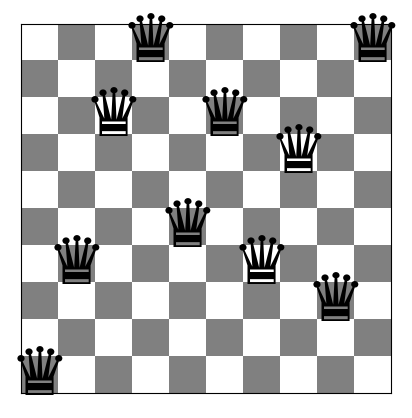

Queens (left to right) are at rows: [9 6 2 0 5 2 6 3 7 0]
Number of conflicts: 9


In [5]:
board = random_board(10)

show_board(board)
print(f"Queens (left to right) are at rows: {board}")
print(f"Number of conflicts: {conflicts(board)}")

A board $4 \times 4$ with no conflicts:

board = [1,0,3,2]
show_board(board)

# Tasks

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision. 
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Steepest-ascend Hill Climbing Search [20 Points]

Calculate the objective function for all local moves (see definition of local moves above) and always choose the best among all local moves. If there are no local moves that improve the objective, then you have reached a local optimum. 

In [37]:
def steepest(board, verb = True):
    # tạo một bàn cờ copy
    bc = np.copy(board)

    # while sol là đúng
    sol = True
    opt = False
    while sol:
        nbr_dict = {}
        nbr = np.copy(bc)
        # nested for loop to loop through each column and row
        for i in range(len(bc)):
            for j in range(len(bc)):
                # change col i to value j
                nbr[i] = j
                # if conflicts less than board copy add to dict
                if conflicts(nbr) <= conflicts(bc):
                    nbr_dict[conflicts(nbr)] = nbr
                # reestablish neighbor board to have same starting point
                nbr = np.copy(bc)
        # if local min found, stop
        if conflicts(bc) == min(nbr_dict.keys()):
            if verb:
                print('local optimum found, global optimum not found')
            sol = False
        # board copy is the neighbor with the lowest conflicts
        bc = nbr_dict[min(nbr_dict.keys())]
        # if conflicts is zero, global optimum found, stop
        if conflicts(bc) == 0:
            if verb:
                print('global/local optimum found')
            opt = True
            sol = False
    return [opt,bc]

In [38]:
board = random_board(4)
steepest(board)

local optimum found, global optimum not found


[False, array([3, 0, 2, 1], dtype=int32)]

## Task 2: Stochastic Hill Climbing 1 [10 Points]

Chooses randomly from among all uphill moves till you have reached a local optimum.

In [39]:
def stochastic(board, verb = True):
    bc = np.copy(board)
    sol = True
    opt = False
    while sol:
        nbr_dict = {}
        nbr = np.copy(bc)
        for i in range(len(bc)):
            for j in range(len(bc)):
                nbr[i] = j
                if conflicts(nbr) <= conflicts(bc):
                    nbr_dict[conflicts(nbr)] = nbr
                nbr = np.copy(bc)
        if conflicts(bc) == min(nbr_dict.keys()):
            if verb:
                print('local optimum found, global optimum not found')
            sol = False
        # choose next board randomly from dict of neighbors
        bc = nbr_dict[random.choice(list(nbr_dict.keys()))]
        if conflicts(bc) == 0:
            if verb:
                print('global/local optimum found')
            opt = True
            sol = False
    return [opt,bc]

In [44]:
board = random_board(4)
stochastic(board)

global/local optimum found


[True, array([2, 0, 3, 1], dtype=int32)]

## Task 3: Stochastic Hill Climbing 2 [20 Points]

A popular version of stochastic hill climbing generates only a single random local neighbor at a time and accept it if it has a better objective function value than the current state. This is very efficient if each state has many possible successor states. This method is called "First-choice hill climbing" in the textbook.

__Notes:__ 

* Detecting local optima is tricky! You can, for example, stop if you were not able to improve the objective function during the last $x$ tries.

In [42]:
def first_choice(board, verb = True, tries = 50):
    bc = np.copy(board)
    sol = True
    opt = False
    n = 0
    while sol:
        nbr = np.copy(bc)
        length = [i for i in range(len(bc))]
        # randomly shuffle rows and columns
        random.shuffle(length)
        for i in length:
            find = False
            random.shuffle(length)
            for j in length:
                nbr[i] = j
                # if first choice has less conflicts than current board, board copy is first choice
                if conflicts(nbr) < conflicts(bc):
                    n = 0
                    bc = np.copy(nbr)
                    find = True
                    break
                # if conflicts of neighbor are greater than or equal to current board add one to n, if n is more than tries, found local optimum
                elif conflicts(nbr) >= conflicts(bc):
                    n += 1
                    if n >= tries:
                        find = True
                        break
                nbr = np.copy(bc)
            if find:
                break

        if n >= tries:         
            if verb:
                print('local optimum found, global optimum not found')
            sol = False

        if conflicts(bc) == 0:
            if verb:
                print('global/local optimum found')
            opt = True
            sol = False
    return [opt,bc]

In [43]:
board = random_board(4)
first_choice(board)

global/local optimum found


[True, array([2, 0, 3, 1], dtype=int32)]

## Task 4: Hill Climbing Search with Random Restarts [10 Points]

Hill climbing will often end up in local optima. Restart the each of the three hill climbing algorithm up to 100 times with a random board to find a better (hopefully optimal) solution. Note that restart just means to run the algorithm several times starting with a new random board.

In [45]:
def random_restart(board, alg = steepest, verb = False, tries = 5, p = False):
    bc = np.copy(board)
    board_len = len(board)
    sol = False
    
    if alg != first_choice:
        # first argument returned from funnction is boolean for T/F
        opt = alg(bc,verb)[0]
        current_bc = alg(bc,verb)[1]
        # if found optimum solution, return solution
        if opt == True:
            if p:
                print('global/local optimum found')
            return [opt,current_bc]
        # else, create new random state and call function again
        else:
            # try 100 times to find an optimum solution
            for i in range(100):
                bc = np.copy(random_board(board_len))
                opt = alg(bc,verb)[0]
                current_bc = alg(bc,verb)[1]
                if opt == False:
                    continue
                elif opt == True:
                    sol = True
                    if p:
                        print('global/local optimum found')
                    return [opt,current_bc]
    # parameters for first_choice is different, so have different call to function
    else:
        opt = alg(bc,verb, tries)[0]
        current_bc = alg(bc,verb, tries)[1]
        if opt == True:
            if p:
                print('global/local optimum found')
            return [opt,current_bc]
        else:
            for i in range(100):
                bc = np.copy(random_board(board_len))
                opt = alg(bc,verb,tries)[0]
                current_bc = alg(bc,verb,tries)[1]
                if opt == False:
                    continue
                elif opt == True:   
                    sol = True
                    if p:
                        print('global/local optimum found')
                    return [opt,current_bc]
    # if optimum solution not found, sol = false and return local optimum solution
    if sol == False:
        if p:
            print('local optimum found, global optimum not found')
        return [opt,bc]

In [46]:
board = random_board(4)
random_restart(board, alg=first_choice)

[True, array([2, 0, 3, 1], dtype=int32)]

## Task 5: Simulated Annealing [10 Points]

Simulated annealing is a form of stochastic hill climbing that avoid local optima by also allowing downhill moves with a probability proportional to a temperature. The temperature is decreased in every iteration following an annealing schedule. You have to experiment with the annealing schedule (Google to find guidance on this).


1. Implement simulated annealing for the n-Queens problem.
2. Create a visualization of the search process (a line chart of how the number if conflict changes as the algorithm progrsses).
3. Use this visualization for experiments with different choices for the annealing schedule and discuss what you have learned.

In [48]:
def classic(t0, t):
    return t0*(1/math.log(1+t))
def fast(t0,t):
    return t0*(1/(1+t))
def exponential(t0,t,a):
    if a < 0.8 or a > 1:
        print('Improper a parameter. nằm trong khoảng 0.8 và 1 ')
        return
    return t0*(a**(t))
def simulated_annealing(board, t0 = 20 , a = 0.99, ep = 0.01, schedule = exponential, verb = False):
    bc = np.copy(board)
    opt = False
    t = 1

    while t < math.inf:
        # call schedule function
        if schedule != exponential:
            T = schedule(t0,t)
        # exponential schedule is different
        else:
            T = schedule(t0,t,a)

        # loop until T is less than epsilon parameter
        if T < ep:
            if conflicts(bc) == 0:
                if verb:
                    print('global/local optimum found')
                opt = True
                return [opt,bc]
            if verb:
                print('local optimum found, global optimum not found')
            return [opt,bc]
        nbr_dict = {}
        nbr = np.copy(bc)
        for i in range(len(bc)):
            for j in range(len(bc)):
                nbr[i] = j
                nbr_dict[conflicts(nbr)] = nbr
                nbr = np.copy(bc)
        # randomly select successor of current
        next = nbr_dict[random.choice(list(nbr_dict.keys()))]

        # e is difference in conflicts
        e = conflicts(bc) - conflicts(next)
        # if e is greater thanb 0, take
        if e > 0: 
            bc = np.copy(next)
        # else, there is chance to take given cooling schedule
        else: 
            prob = random.random()
            if prob <= math.exp(e/T):
                bc = np.copy(next)
        t+=1

In [49]:
board = random_board(4)
simulated_annealing(board)

[True, array([2, 0, 3, 1], dtype=int32)]

In [50]:
board = random_board(4)
simulated_annealing(board,schedule=fast)

[True, array([2, 0, 3, 1], dtype=int32)]

In [51]:
board = random_board(4)
simulated_annealing(board, schedule = exponential)

[True, array([2, 0, 3, 1], dtype=int32)]

In [52]:
import timeit

# parameter tuning for schedule type
N = 100
classic_4 = timeit.timeit('simulated_annealing(random_board(4), schedule=classic, verb=False)', number = N, globals = globals())
avg_classic_4 = (classic_4/N*1e3)

fast_4 = timeit.timeit('simulated_annealing(random_board(4), schedule=fast, verb=False)', number = N, globals = globals())
avg_fast_4 = (fast_4/N*1e3)

exponential_4 = timeit.timeit('simulated_annealing(random_board(4), schedule=exponential, verb=False)', number = N, globals = globals())
avg_exponential_4 = (exponential_4/N*1e3)

KeyboardInterrupt: 

In [53]:
schedules = [classic, fast, exponential]
times = [avg_classic_4, avg_fast_4, avg_exponential_4]

idx = -1
# fast has the fastest runtime of 1.3 ms followed by exponential at 3.06 ms
for schedule in schedules:
    idx += 1
    print(f'Schedule {schedule} has a runtime of {times[idx]}')

NameError: name 'avg_classic_4' is not defined

In [54]:
schedules = [classic, fast, exponential]
schedules_acc = [0,0,0]
N = 100
idx = -1

for schedule in schedules:
    idx += 1
    for i in range(N):
        if simulated_annealing(random_board(4), schedule=schedule, verb=False)[0] == True:
            schedules_acc[idx] += 1

for i in range(3):
    schedules_acc[i] = schedules_acc[i]/N

# exponential and classic have the highest accuracies of about 31-32%
# choose to use exponential for a balance of accuracy and low runtime
idx = -1
for schedule in schedules:
    idx += 1
    print(f'Schedule {schedule} has an accuracy of {schedules_acc[idx]}')

KeyboardInterrupt: 

In [ ]:
# parameter tuning for t0

t = [0.001, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
t_acc = [0,0,0,0,0,0,0,0,0]
N = 500
idx = -1

for t0 in t:
    idx += 1
    for i in range(N):
        if simulated_annealing(random_board(4), t0=t0, schedule=exponential, verb=False)[0] == 1:
            t_acc[idx] += 1

for i in range(9):
    t_acc[i] = t_acc[i]/N

# using a t0 of 20 has the highest accuracy
t_acc

In [ ]:
# parameter tuning for ep
ep = [0.001, 0.01, 0.1, 0.5]
ep_acc = [0,0,0,0]
N = 500
idx = -1

for e in ep:
    idx += 1
    for i in range(N):
        if simulated_annealing(random_board(4), t0=20, ep=e, schedule=exponential, verb=False)[0] == 1:
            ep_acc[idx] += 1

for i in range(4):
    ep_acc[i] = ep_acc[i]/N

# 0.01 has the highest accuracy
ep_acc

In [ ]:
# parameter tuning for a since we chose exponential
a = [0.8,0.9,.99]
a_acc = [0,0,0]
N = 500
idx = -1

for _a in a:
    idx += 1
    for i in range(N):
        if simulated_annealing(random_board(4), t0=20, a=_a, ep=0.01, schedule=exponential, verb=False)[0] == 1:
            a_acc[idx] += 1

for i in range(3):
    a_acc[i] = a_acc[i]/N

# 0.99 has the highest accuracy
a_acc

## Task 6: Algorithm Behavior Analysis [20 Points]

### Comparison
Compare the algorithm using runtime and objective function values. Use boards of size 4 and 8 to explore how the different algorithms perform. Make sure that you run the algorithms for each board size several times (at least 100 times) with different starting boards and report averages.

Complete the following table

| Algorithm           | Board size | Avg. Run time | Avg. number of conflicts | % of runs ending in optimal solution  |
| ------------------- | ---------- | ------------- | --------------------------------- | - |
| Steepest asc. HC    |     4      |               |                                   |   |
| Stochastic HC 1     |     4      |               |                                   |   |
| Stochastic HC 2     |     4      |               |                                   |   |
| Simulated Annealing |     4      |               |                                   |   |
| Steepest asc. HC    |     8      |               |                                   |   |
| Stochastic HC 1     |     8      |               |                                   |   |
| Stochastic HC 2     |     8      |               |                                   |   |
| Simulated Annealing |     8      |               |                                   |   |

Hint: See [Profiling Python Code](../HOWTOs/profiling_code.ipynb) for help about how to measure runtime in Python.

Add the used code here:

In [ ]:
# Code

### Algorithm Convergence

For each algorithm implemented, describe the typical convergence pattern (fast initial improvement vs. steady progress).
Include a plot showing the objective function value over iterations for one representative run of each algorithm on the 8-queens problem.
Explain which algorithms exhibit plateaus or getting stuck in local optima most frequently.

In [ ]:
# Code and description go here

### Problem Size Scalability

Create a log-log plot showing how runtime scales with board size ($n=4, 8, 12, 16, 20$) for at least two algorithms.
Estimate the empirical time complexity (Big O) for each algorithm based on your results.
Identify which algorithm scales best for large problem sizes and explain why.

In [ ]:
# Code and description go here

## Advanced task: Exploring other Local Moves Operators

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### Move Operator Implementation 

Implement the following local move operators:

* Single-step move: Move one queen only one square up or down at a time
* Column swap: Exchange the positions of queens in two randomly selected columns
* Dual-queen move: Select two queens and move both simultaneously
* Adaptive move: Design your own operator that adapts which local move it uses based on the current state (e.g., focuses on queens with most conflicts or randomly chooses one of the moves above)

### Experimental Analysis

Using the 8-Queens and 12-Queens problems: Run your Stochastic Hill Climbing 2 implementation with each move operator 100 times
For each operator, create a visualization showing:

* Average solution quality over iterations
* Distribution of final solution qualities
* Average time to solution for successful runs

### Discussion

Describe what you have learned from the experiments. Which operator works best for which situation and why?

In [9]:
# Code and description go here

## More Things to Do (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment. 

### Implement a Genetic Algorithm for the n-Queens problem

In [10]:
# Code and description go here